### ReAct Pattern (Agentic)

This pattern has three steps that run in a loop to arive at the answer:
* Thought
* Action
* Observation

In [1]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage,AIMessage, HumanMessage, AnyMessage
from langchain_core.tools import tool

from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_tavily import TavilySearch

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages ## used for adding messages to the list in state (reducer)

# use this to import tool_condition and ToolNode
from langgraph.prebuilt import ToolNode, tools_condition

from typing import Annotated
from pydantic import BaseModel
from dotenv import load_dotenv
import requests
import os

load_dotenv()

/Users/srinivas/Documents/Others/My_projects/Python/DSAIML/agenticai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
# set the project name for tracing
os.environ["LANGCHAIN_PROJECT"] = "ReAct Agent"

In [3]:
# Initialize open ai model using init_chat_model (newer way of setting up models in langchain)
model = init_chat_model(
    model="gpt-4.1-mini", 
    model_provider="openai",
    temperature=0.7,
)

In [4]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv_tool = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

api_wrapper_wikipedia = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=500)
wikipedia_tool = WikipediaQueryRun(api_wrapper=api_wrapper_wikipedia)

In [5]:
## to invoke these tools
# arxiv_tool.invoke("machine learning")
wikipedia_tool.invoke("machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [6]:
## create other tools - tavily
tvaily_tool = TavilySearch()
tvaily_tool.invoke("machine learning")

{'query': 'machine learning',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.geeksforgeeks.org/machine-learning/machine-learning/',
   'title': 'Machine Learning Tutorial - GeeksforGeeks',
   'content': 'Machine learning is a branch of Artificial Intelligence that focuses on developing models and algorithms that let computers learn from data',
   'score': 0.8921218,
   'raw_content': None},
  {'url': 'https://www.coursera.org/articles/what-is-machine-learning',
   'title': 'What Is Machine Learning? Definition, Types, and Examples',
   'content': '# What Is Machine Learning? Machine learning is a subfield of artificial intelligence that uses algorithms trained on data sets to create models capable of performing tasks that would otherwise only be possible for humans, such as categorizing images, analyzing data, or predicting price fluctuations. Machine learning is a subfield of artificial intelligence (AI) that uses algorithms trained on 

In [7]:
# custom tool - for weather

@tool
def get_weather_tool(city: str):
    """
    Given a city name, this function will provide weather information about the city.
    Uses Weatherstack API to fetch the weather.
    """
    url = f'https://api.weatherstack.com/current?access_key={os.getenv("WEATHER_API_KEY")}&query={city}'

    response = requests.get(url)

    return response.json()

# get_weather_tool.name
# get_weather_tool.description
# get_weather_tool.args

get_weather_tool.invoke("Bengaluru")

{'request': {'type': 'City',
  'query': 'Bengaluru, India',
  'language': 'en',
  'unit': 'm'},
 'location': {'name': 'Bengaluru',
  'country': 'India',
  'region': 'Karnataka',
  'lat': '12.983',
  'lon': '77.583',
  'timezone_id': 'Asia/Kolkata',
  'localtime': '2025-11-30 03:45',
  'localtime_epoch': 1764474300,
  'utc_offset': '5.50'},
 'current': {'observation_time': '10:15 PM',
  'temperature': 19,
  'weather_code': 143,
  'weather_icons': ['https://cdn.worldweatheronline.com/images/wsymbols01_png_64/wsymbol_0006_mist.png'],
  'weather_descriptions': ['Mist'],
  'astro': {'sunrise': '06:25 AM',
   'sunset': '05:51 PM',
   'moonrise': '01:52 PM',
   'moonset': '01:31 AM',
   'moon_phase': 'Waxing Gibbous',
   'moon_illumination': 68},
  'air_quality': {'co': '415.85',
   'no2': '21.05',
   'o3': '67',
   'so2': '13.05',
   'pm2_5': '27.65',
   'pm10': '27.95',
   'us-epa-index': '2',
   'gb-defra-index': '2'},
  'wind_speed': 12,
  'wind_degree': 16,
  'wind_dir': 'NNE',
  'pressu

In [8]:
# some more custom tools

@tool
def add_tool(a: int, b: int) -> int:
    """Add two numbers given two inputs."""
    return a + b

@tool
def subtract_tool(a: int, b: int) -> int:
    """Subtract two numbers given two inputs."""
    return a - b

@tool
def multiply_tool(a: int, b: int) -> int:
    """Multiply two numbers given two inputs."""
    return a * b

@tool
def divide_tool(a: int, b: int) -> int:
    """Divide two numbers given two inputs."""
    if b == 0:
        raise ValueError("Cannot divide by zero")
    return a / b

In [9]:
# let us create a list of tools
tools = [arxiv_tool, wikipedia_tool, tvaily_tool, get_weather_tool, add_tool, subtract_tool, multiply_tool, divide_tool]

# bind the tools to the model
model_with_tools = model.bind_tools(tools=tools)

In [10]:
# let us build the State (chat state)

class ChatState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]

In [11]:
# let us implement the chat node
def chat_node(state: ChatState) -> ChatState:
    response = model_with_tools.invoke(state.messages)
    state.messages = state.messages + [response]
    return state

In [12]:
tools_node = ToolNode(tools)

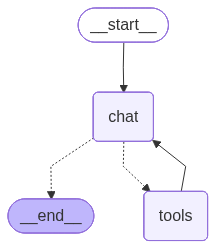

In [13]:
# now lets build a graph with tools

# initialize the graph
graph = StateGraph(ChatState)

# add nodes
graph.add_node("chat", chat_node)
graph.add_node("tools", tools_node)

# add edges
graph.add_edge(START, "chat")
graph.add_conditional_edges("chat", tools_condition)
graph.add_edge("tools", "chat")
graph.add_edge("chat", END)

# compile the graph
workflow_with_tools = graph.compile()
workflow_with_tools

In [14]:
# invoke the workflow
initial_state = {"messages": [HumanMessage(content="Hello")]}
workflow_with_tools.invoke(initial_state)

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='d8e11ee5-830f-4c5c-af65-4c88c60d47ea'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 1540, 'total_tokens': 1550, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_24710c7f06', 'id': 'chatcmpl-ChNVgEgddQBjWLZhGLSyrdmnnzuk0', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--ad0b21a0-48aa-482f-b8d3-b0c63f1563d4-0', usage_metadata={'input_tokens': 1540, 'output_tokens': 10, 'total_tokens': 1550, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning

In [15]:
# lets mimic a chatbot

while True:
    user_input = input("You: ")
    if user_input.lower() in ["quit", "exit"]:
        break
    print("You:", user_input)
    initial_state = {"messages": [HumanMessage(content=user_input)]}
    response = workflow_with_tools.invoke(initial_state)
    print("Bot:", response["messages"][-1].content)

You: Hi
Bot: Hello! How can I assist you today?
You: Give me top 5 news in AI world, then add 5 with 5 then subtract it with 2 and later divide by 4
Bot: Here are the top 5 news in the AI world:

1. New AI models that detect dementia with high accuracy using EEG signals.
2. TikTok rolls out new tools for transparency around AI-generated content.
3. Alibaba launches new Quark AI glasses series in China, deeply integrated with Qwen.
4. New York City Council sets up a new AI oversight office.
5. US Patent Office issues new guidelines for AI-assisted inventions.

Regarding the math operations you requested:
- 5 plus 5 equals 10.
- 10 minus 2 equals 8.
- 8 divided by 4 equals 2.

If you need more details on any of the AI news or further assistance, feel free to ask!
